In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import gzip
import os
import matplotlib.pyplot as plt

In [8]:
def read_pkl_gz(filepath):
    with gzip.open(filepath, 'rb') as f:
        return pkl.load(f)

community = 'math.stackexchange.com'
f_headers = ['comments', 'monthly_posts', 'users', 'tags']
data = {}
for x in f_headers:
    data[x] = read_pkl_gz(f'data/processed/parsed/{community}/{x}.pkl.gz')

all_months = data['monthly_posts'].keys()
all_questions = pd.concat([pd.DataFrame(data['monthly_posts'][x]['questions']) for x in all_months])
all_answers = pd.concat([pd.DataFrame(data['monthly_posts'][x]['answers']) for x in all_months])
answered = pd.merge(all_questions, all_answers[['post_id', 'creation_date']].rename(columns={'post_id': 'accepted_answer_id', 'creation_date': 'accepted_answer_creation_date'}), left_on='accepted_answer_id', right_on='accepted_answer_id', how='left')

In [11]:
# Load comments data
all_comments = pd.DataFrame(data['comments'])
all_comments['creation_date'] = pd.to_datetime(all_comments['creation_date'])

# Ensure all data has datetime and user_id properly formatted
all_questions['creation_date'] = pd.to_datetime(all_questions['creation_date'])
all_answers['creation_date'] = pd.to_datetime(all_answers['creation_date'])
all_questions['user_id'] = all_questions['user_id'].astype(str)
all_answers['user_id'] = all_answers['user_id'].astype(str)
all_comments['user_id'] = all_comments['user_id'].astype(str)

# Add month and day columns
all_questions['month'] = all_questions['creation_date'].dt.to_period('M')
all_questions['day'] = all_questions['creation_date'].dt.date

# 1. Questions per day
questions_per_day = all_questions.groupby('day').size().reset_index(name='questions_per_day')

# 2. Answer rates within 7, 14, 30 days for any and accepted answers
# Create lookup dictionaries
answers_by_question = all_answers.groupby('parent_id')['creation_date'].apply(list).to_dict()
all_answers['post_id_str'] = all_answers['post_id'].astype(str)
accepted_answers_lookup = all_answers.set_index('post_id_str')['creation_date'].to_dict()

def calculate_answer_rates(row, days_list=[7, 14, 30]):
    """Calculate answer rates for multiple day thresholds"""
    question_date = row['creation_date']
    question_post_id = str(row['post_id'])
    accepted_answer_id = str(row['accepted_answer_id']) if pd.notna(row['accepted_answer_id']) else None
    
    result = {}
    
    # Check for any answer
    for days in days_list:
        any_within = False
        if question_post_id in answers_by_question:
            answer_dates = answers_by_question[question_post_id]
            for answer_date in answer_dates:
                time_diff = (answer_date - question_date).total_seconds() / 86400
                if 0 <= time_diff <= days:
                    any_within = True
                    break
        result[f'any_answer_within_{days}d'] = any_within
    
    # Check for accepted answer
    for days in days_list:
        accepted_within = False
        if accepted_answer_id and accepted_answer_id in accepted_answers_lookup:
            accepted_date = accepted_answers_lookup[accepted_answer_id]
            time_diff = (accepted_date - question_date).total_seconds() / 86400
            if 0 <= time_diff <= days:
                accepted_within = True
        result[f'accepted_answer_within_{days}d'] = accepted_within
    
    return pd.Series(result)

print('Calculating answer rates for all questions...')
answer_rates = all_questions.apply(calculate_answer_rates, axis=1)
for col in answer_rates.columns:
    all_questions[col] = answer_rates[col]

# Calculate monthly answer rate statistics
monthly_answer_cols = [f'{t}_answer_within_{d}d' for t in ['any', 'accepted'] for d in [7, 14, 30]]
monthly_answer_stats = all_questions.groupby('month').agg({
    'post_id': 'count',
    **{col: 'sum' for col in monthly_answer_cols}
}).rename(columns={'post_id': 'total_questions'})

# Calculate percentages
for col in monthly_answer_cols:
    monthly_answer_stats[f'pct_{col}'] = (monthly_answer_stats[col] / monthly_answer_stats['total_questions']) * 100

# 3. Retention rate: Fraction of users active 6-12 months ago that were also active in last 6 months
# Combine all activities (questions, answers, comments)
all_activities = pd.concat([
    all_questions[['user_id', 'creation_date']].assign(activity_type='question'),
    all_answers[['user_id', 'creation_date']].assign(activity_type='answer'),
    all_comments[['user_id', 'creation_date']].assign(activity_type='comment')
])

all_activities['month'] = all_activities['creation_date'].dt.to_period('M')

# Get unique active users per month
users_by_month = all_activities.groupby('month')['user_id'].apply(set).to_dict()

# Calculate retention rate for each month
def calculate_retention_rate(current_month_period):
    """Calculate retention rate for a given month"""
    # Users active 6-12 months ago (relative to current month)
    try:
        months_6_12_ago = []
        for i in range(7, 13):  # 7 to 12 months ago
            target_month = current_month_period - i
            if target_month in users_by_month:
                months_6_12_ago.append(users_by_month[target_month])
        
        if not months_6_12_ago:
            return None
        
        users_6_12_ago = set().union(*months_6_12_ago)
        
        # Users active in last 6 months (relative to current month)
        months_last_6 = []
        for i in range(1, 7):  # 1 to 6 months ago
            target_month = current_month_period - i
            if target_month in users_by_month:
                months_last_6.append(users_by_month[target_month])
        
        users_last_6 = set().union(*months_last_6) if months_last_6 else set()
        
        # Retention: users active in both periods
        if len(users_6_12_ago) == 0:
            return None
        
        retained_users = users_6_12_ago.intersection(users_last_6)
        return len(retained_users) / len(users_6_12_ago) * 100
    except:
        return None

# Calculate retention for all months
all_months_sorted = sorted([pd.Period(m) for m in users_by_month.keys()])
retention_rates = {}
for month in all_months_sorted:
    retention = calculate_retention_rate(month)
    if retention is not None:
        retention_rates[month] = retention

# 4. New user rate: New users who posted this month
# Track cumulative users seen up to each month
cumulative_users = set()
new_user_counts = {}

for month in all_months_sorted:
    current_month_users = users_by_month[month]
    new_users = current_month_users - cumulative_users
    new_user_counts[month] = len(new_users)
    cumulative_users.update(current_month_users)

# Combine all metrics into a single dataframe
# Start with monthly base
metrics_df = pd.DataFrame(index=all_months_sorted)
metrics_df.index.name = 'month'

# Add questions per day (aggregated by month for consistency)
questions_per_month = all_questions.groupby('month').size()
metrics_df['questions_per_month'] = questions_per_month

# Add answer rates
for col in [f'pct_{c}' for c in monthly_answer_cols]:
    metrics_df[col] = monthly_answer_stats[col]

# Add retention rate
metrics_df['retention_rate_pct'] = pd.Series(retention_rates)

# Add new user count and rate
metrics_df['new_users_count'] = pd.Series(new_user_counts)
metrics_df['total_users_this_month'] = pd.Series({m: len(users_by_month[m]) for m in all_months_sorted})
metrics_df['new_user_rate_pct'] = (metrics_df['new_users_count'] / metrics_df['total_users_this_month']) * 100

# Clean up the dataframe
metrics_df = metrics_df.fillna(0)


Calculating answer rates for all questions...


<Axes: xlabel='month'>

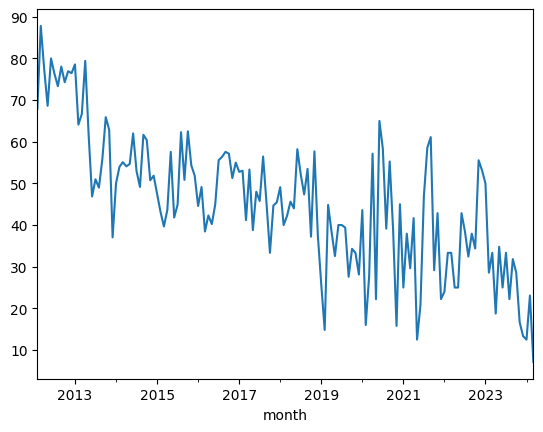

In [ ]:
metrics_df.pct_accepted_answer_within_14d.plot()

In [5]:
metrics_df

,questions_per_month,pct_any_answer_within_7d,pct_any_answer_within_14d,pct_any_answer_within_30d,pct_accepted_answer_within_7d,pct_accepted_answer_within_14d,pct_accepted_answer_within_30d,retention_rate_pct,new_users_count,total_users_this_month,new_user_rate_pct
month,,,,,,,,,,,
2012-02,143,95.804196,96.503497,97.902098,65.734266,67.832168,69.230769,0.000000,122,122,100.000000
2012-03,41,95.121951,97.560976,97.560976,85.365854,87.804878,87.804878,0.000000,35,66,53.030303
2012-04,31,93.548387,93.548387,93.548387,77.419355,77.419355,80.645161,0.000000,25,53,47.169811
2012-05,51,92.156863,96.078431,100.000000,64.705882,68.627451,70.588235,0.000000,38,66,57.575758
2012-06,40,92.500000,95.000000,95.000000,80.000000,80.000000,80.000000,0.000000,26,56,46.428571
...,...,...,...,...,...,...,...,...,...,...,...
2023-11,18,44.444444,44.444444,44.444444,16.666667,16.666667,16.666667,22.424242,13,33,39.393939
2023-12,15,66.666667,73.333333,73.333333,13.333333,13.333333,13.333333,23.214286,11,37,29.729730
2024-01,16,68.750000,68.750000,68.750000,12.500000,12.500000,12.500000,23.899371,16,44,36.363636


,post_id,user_id,tags,score,view_count,answer_count,accepted_answer_id,creation_date,accepted_answer_creation_date
0,1,16,"[resolution, speed, quality]",11,458,2,51,2016-01-12T18:45:19.963,2016-01-12T20:20:17.790
1,2,20,"[print-material, safety, health]",35,8486,4,12,2016-01-12T18:45:51.287,2016-01-12T19:13:00.710
2,3,11,"[quality, resolution]",19,2709,3,152,2016-01-12T18:46:22.083,2016-01-13T06:39:29.060
3,4,16,"[fdm, material, print-material, metal-parts]",19,392,4,1289,2016-01-12T18:50:55.973,2016-06-09T19:34:53.960
4,5,11,"[filament, abs, fdm, pla]",41,4096,5,77,2016-01-12T18:53:53.623,2016-01-12T21:29:04.420
...,...,...,...,...,...,...,...,...,...
5730,23179,42880,"[3d-models, fusion360, medical]",3,27,0,None,2024-03-27T21:29:57.447,NaN
5731,23181,12999,"[marlin, g-code, extrusion, stepper, e-value]",1,34,1,None,2024-03-28T11:50:57.693,NaN
5732,23182,42887,"[marlin, ramps-1.4, arduino-mega-2650]",3,50,1,None,2024-03-28T14:43:11.680,NaN
5733,23183,42890,"[pla, g-code, heated-bed, temperature]",2,74,2,None,2024-03-28T15:31:05.850,NaN


In [58]:
all_questions

,post_id,user_id,tags,score,view_count,answer_count,accepted_answer_id,creation_date
0,1,16,"[resolution, speed, quality]",11,458,2,51,2016-01-12T18:45:19.963
1,2,20,"[print-material, safety, health]",35,8486,4,12,2016-01-12T18:45:51.287
2,3,11,"[quality, resolution]",19,2709,3,152,2016-01-12T18:46:22.083
3,4,16,"[fdm, material, print-material, metal-parts]",19,392,4,1289,2016-01-12T18:50:55.973
4,5,11,"[filament, abs, fdm, pla]",41,4096,5,77,2016-01-12T18:53:53.623
...,...,...,...,...,...,...,...,...
22,23179,42880,"[3d-models, fusion360, medical]",3,27,0,None,2024-03-27T21:29:57.447
23,23181,12999,"[marlin, g-code, extrusion, stepper, e-value]",1,34,1,None,2024-03-28T11:50:57.693
24,23182,42887,"[marlin, ramps-1.4, arduino-mega-2650]",3,50,1,None,2024-03-28T14:43:11.680
25,23183,42890,"[pla, g-code, heated-bed, temperature]",2,74,2,None,2024-03-28T15:31:05.850


In [50]:
tmp = pd.concat([pd.DataFrame(data['monthly_posts'][x]['answers']) for x in all_months])

In [53]:
tmp.loc[tmp.post_id == '51']

,post_id,parent_id,parent_month,parent_tags,user_id,score,creation_date
22,51,1,2016-01,"[resolution, speed, quality]",53,8,2016-01-12T20:20:17.790


In [55]:
tmp.loc[tmp.parent_id == '2']

,post_id,parent_id,parent_month,parent_tags,user_id,score,creation_date
0,9,2,2016-01,"[print-material, safety, health]",16,18,2016-01-12T18:58:04.410
1,12,2,2016-01,"[print-material, safety, health]",26,23,2016-01-12T19:13:00.710
2,15,2,2016-01,"[print-material, safety, health]",10,5,2016-01-12T19:25:07.817
88,176,2,2016-01,"[print-material, safety, health]",188,10,2016-01-13T13:42:23.683


In [52]:
tmp

,post_id,parent_id,parent_month,parent_tags,user_id,score,creation_date
0,9,2,2016-01,"[print-material, safety, health]",16,18,2016-01-12T18:58:04.410
1,12,2,2016-01,"[print-material, safety, health]",26,23,2016-01-12T19:13:00.710
2,15,2,2016-01,"[print-material, safety, health]",10,5,2016-01-12T19:25:07.817
3,17,4,2016-01,"[fdm, material, print-material, metal-parts]",40,5,2016-01-12T19:27:20.113
4,18,10,2016-01,"[material, fdm, outdoors]",26,11,2016-01-12T19:28:04.263
...,...,...,...,...,...,...,...
32,23169,23165,2024-03,"[creality-cr-10, underextrusion, stringing, di...",40817,1,2024-03-23T08:49:51.177
33,23174,6439,2018-07,[print-material],4762,1,2024-03-25T19:31:54.393
34,23175,20935,2023-05,"[resin, lcd-screen, elegoo-mars]",4762,2,2024-03-25T19:37:20.913
35,23184,23183,2024-03,"[pla, g-code, heated-bed, temperature]",29097,2,2024-03-28T17:26:32.153


In [45]:
pd.DataFrame(data['comments'])

,comment_id,post_id,user_id,score,creation_date
0,1,1,23,4,2016-01-12T18:47:12.573
1,3,1,26,1,2016-01-12T19:42:08.613
2,9,1,16,1,2016-01-12T19:55:46.737
3,6812,1,4639,0,2017-10-31T01:16:24.713
4,6813,1,16,0,2017-10-31T01:19:24.047
...,...,...,...,...,...
25509,41775,23183,4762,0,2024-03-29T15:33:59.953
25510,41776,23183,42890,0,2024-03-29T16:15:49.047
25511,41783,23185,42890,0,2024-03-30T19:42:00.430
25512,41784,23185,5740,0,2024-03-30T22:03:30.373


In [29]:
pd.DataFrame(data['monthly_posts']['2016-01']['questions'])

,post_id,user_id,tags,score,view_count,answer_count,accepted_answer_id,creation_date
0,1,16,"[resolution, speed, quality]",11,458,2,51,2016-01-12T18:45:19.963
1,2,20,"[print-material, safety, health]",35,8486,4,12,2016-01-12T18:45:51.287
2,3,11,"[quality, resolution]",19,2709,3,152,2016-01-12T18:46:22.083
3,4,16,"[fdm, material, print-material, metal-parts]",19,392,4,1289,2016-01-12T18:50:55.973
4,5,11,"[filament, abs, fdm, pla]",41,4096,5,77,2016-01-12T18:53:53.623
...,...,...,...,...,...,...,...,...
116,409,334,"[printer-building, desktop-printer, diy-3d-pri...",15,1767,4,411,2016-01-27T14:26:50.577
117,410,334,[filament],7,255,1,412,2016-01-27T14:30:41.597
118,413,334,"[post-processing, smoothing]",2,1012,2,414,2016-01-27T16:25:12.577
119,418,292,"[pla, safety]",1,85,0,None,2016-01-29T15:35:24.220


In [39]:
tmp = pd.DataFrame(data['monthly_posts']['2016-02']['answers'])

In [41]:
tmp.post_id.min()

'424'

In [ ]:
# - Average time to accepted response